# Final Project - Reinforcements Learning 
Hello dear students,<br> this is the template notebook. Please click on the "File" tab and then on "Save a copy into drive".

---
<br>

### Name and ID:
Student 1: Avraham Raviv, 204355390
<br>
Student 2: Yevgeni Berkovitch, 317079234
<br><br>
<img src="https://play-lh.googleusercontent.com/e_oKlKPISbgdzut1H9opevS7-LTB8-8lsmpCdMkhlnqFenZhpjxbLmx7l158-xQQCIY">

### https://github.com/mpSchrader/gym-sokoban

# Installs

In [1]:
%%capture
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install gym
!pip install pygame
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!pip install gym
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install gym_sokoban

!imageio_download_bin ffmpeg

# Imports

In [2]:
import random
import time

import numpy as np
import matplotlib.pyplot as plt

import base64
import imageio
from pyvirtualdisplay import Display
from IPython.display import HTML

import gym
from gym import error, spaces, utils
from soko_pap import *

from collections import deque
from queue import PriorityQueue

from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten

In [3]:
%matplotlib inline

In [4]:
imageio.plugins.ffmpeg.download()

In [5]:
from gym import logger as gymlogger
gymlogger.set_level(40) # error only

# Display utils
The cell below contains the video display configuration. No need to make changes here.

In [6]:
def embed_mp4(filename):
    """Embeds an mp4 file in the notebook."""
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())

    return HTML(tag)

# Utils

In [7]:
def get_distances(room_state):
    for i in range(room_state.shape[0]):
        for j in range(room_state.shape[1]):
            if room_state[i][j] == 2:
                target = (i, j)

    distances = np.zeros(shape=room_state.shape)
    visited_cells = set()
    cell_queue = deque()

    visited_cells.add(target)
    cell_queue.appendleft(target)

    while len(cell_queue) != 0:
        cell = cell_queue.pop()
        distance = distances[cell[0]][cell[1]]
        for x,y in ((1,0), (-1,-0), (0,1), (0,-1)):
            next_cell_x, next_cell_y = cell[0]+x, cell[1]+y
            if room_state[next_cell_x][next_cell_y] != 0 and not (next_cell_x, next_cell_y) in visited_cells:
                distances[next_cell_x][next_cell_y] = distance + 1
                visited_cells.add((next_cell_x, next_cell_y))
                cell_queue.appendleft((next_cell_x, next_cell_y))
                
    return distances   

def calc_distances(room_state, distances):
    box = None
    mover = None
    for i in range(room_state.shape[0]):
        for j in range(room_state.shape[1]):            
            if room_state[i][j] == 4:
                box = (i,j)
            
            if room_state[i][j] == 5:
                mover = (i,j)
    
    return mover, box, distances[box[0]][box[1]]   

def box2target_change_reward(room_state, next_room_state, distances):
    if np.array_equal(room_state, next_room_state):
        return -0.5
    
    mover, box, t2b = calc_distances(room_state, distances)
    n_mover, n_box, n_t2b = calc_distances(next_room_state, distances)
    
    change_reward = 0.0
    if n_t2b < t2b:
        change_reward += 1.0
    elif n_t2b > t2b:
        change_reward -= 1.0
        
    m2b = np.sqrt((mover[0]-box[0])**2 + (mover[1]-box[1])**2)
    n_m2b = np.sqrt((n_mover[0]-n_box[0])**2 + (n_mover[1]-n_box[1])**2)
    
    if n_m2b < m2b and m2b >= 2:
        change_reward += 0.25
    elif n_m2b > m2b and n_m2b >= 2:
        change_reward -= 0.25
        
    return change_reward   

In [11]:
def init_sok(r):
    random.seed(r)
    sok = PushAndPullSokobanEnv(dim_room=(7, 7), num_boxes=1)
    return sok

## Training Set

In [10]:
train_episodes = [
    (12, [24, 95]),
    (11, [49, 65]),
    (9,  [2,  86]),
    (8,  [26, 38, 48, 68]),
    (7,  [5,  32, 44, 67]), 
    (6,  [6,  13, 18, 33, 34, 41, 42, 50, 69, 78, 81]),
    (5,  [9,  14, 19, 23, 27, 31, 45, 47, 54, 60, 66, 77, 79, 82, 85]),
    (4,  [28, 59, 62]),
    (3,  [0,  1,  7,  10, 21, 25, 30, 36, 40, 57, 58, 61, 64, 70, 74, 75, 88, 89, 91, 92, 93, 94, 96, 97, 99]), 
    (2,  [8,  11, 12, 35, 43, 46, 71, 72, 73, 80, 84]),
    (1,  [3,  4,  15, 16, 17, 20, 22, 29, 37, 39, 51, 52, 53, 55, 56, 63, 76, 83, 87, 90, 98])    
]

In [ ]:
111, 3, 4, 16, 20, 70, 74, 93, 94, 97

20, 63

0 - wall
1 - empty space
2 - target
3 - box on target
4 - box
5 - agent

In [148]:
clockwise = [2, 3, 3, 1, 1, 4, 4, 2]
anti-clockwise = [1, 3, 3, 2, 2, 4, 4, 1]

def generate_related_puzzles(sok):
    room_state = sok.room_state
    agent, box, target = None, None,None
    for i in range(room_state.shape[0]):
        for j in range(room_state.shape[1]):
            if room_state[i][j] == 5:
                agent = (i,j)
            elif room_state[i][j] == 4:
                box = (i,j)
            elif room_state[i][j] == 2:
                target = (i,j)
    
    a2b = None
    
    if room_state[agent[0]][agent[1]-1] == 4:        
        a2b = 'right'
        sok.step(3)
    elif room_state[agent[0]][agent[1]+1] == 4:       
        a2b = 'left'
        sok.step(4)
    elif room_state[agent[0]-1][agent[1]] == 4:       
        a2b = 'down'
        sok.step(1)
    else:       
        a2b = 'up'
        sok.step(2)

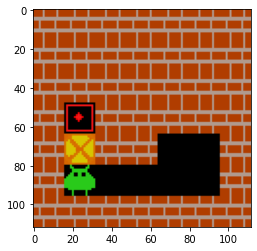

In [155]:
sok = init_sok(16)
screen = sok.get_image('rgb_array')
plt.imshow(screen)

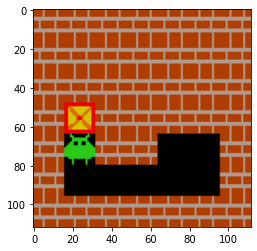

In [156]:
generate_related_puzzles(sok)
screen = sok.get_image('rgb_array')
plt.imshow(screen)